In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
import pyarrow

In [5]:
import freqepid

# 1. parameters

In [6]:
GPi = np.load('data/GPi.npz')

## observation parameters

In [7]:
r_Y = 10

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [8]:
d = 2

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

$$I_{[-T_0,0)} = \mu_0$$

## model

In [9]:
model = freqepid.Model(GPi['g'], GPi['pi'], T0=40, family='nbinom')

# 2. simulation

## random seed

In [10]:
np.random.seed(1111)

## parameter generation

In [11]:
num_region = 100

In [12]:
Ts = np.random.uniform(55, 65, num_region).astype(int)

In [13]:
T1s = np.random.uniform(17, 23, num_region).astype(int)

In [14]:
regions = np.repeat(np.arange(num_region), Ts)

In [15]:
theta_o = np.array([np.log(300), 0, -2])

In [37]:
zeta = np.random.normal(0,1,size=(num_region,3))
eps = zeta @ la.sqrtm([[0.5, 0, 0], [0, 0.3, -0.28], [0, -0.28, 0.3]])
thetas = theta_o + eps

(array([ 2.,  6.,  6., 15., 15., 23., 12., 12.,  5.,  4.]),
 array([-3.21752544, -2.96559028, -2.71365513, -2.46171997, -2.20978481,
        -1.95784966, -1.7059145 , -1.45397934, -1.20204419, -0.95010903,
        -0.69817387]),
 <BarContainer object of 10 artists>)

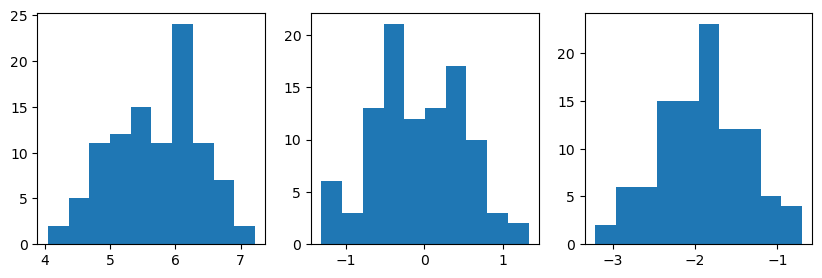

In [38]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.hist(thetas[:,0])
plt.subplot(1,3,2); plt.hist(thetas[:,1])
plt.subplot(1,3,3); plt.hist(thetas[:,2])

## data generateion

In [39]:
As = [
    np.stack([np.full(T, 1), 1 * (np.arange(T) > T1)], -1)
    for T, T1 in zip(Ts, T1s)
]

In [40]:
Rs = [
    model.predict_R(A, th[1:])
    for A, th in zip(As, thetas)
]

In [41]:
Is = [
    model.predict_I(A, th[0], th[1:])
    for A, th in zip(As, thetas)
]

In [42]:
EYs = [
    model.predict_EY(A, th[0], th[1:])
    for A, th in zip(As, thetas)
]

In [43]:
Ys = [
    np.random.negative_binomial(r_Y, r_Y/(r_Y+EY))
    for EY in EYs
]

## result

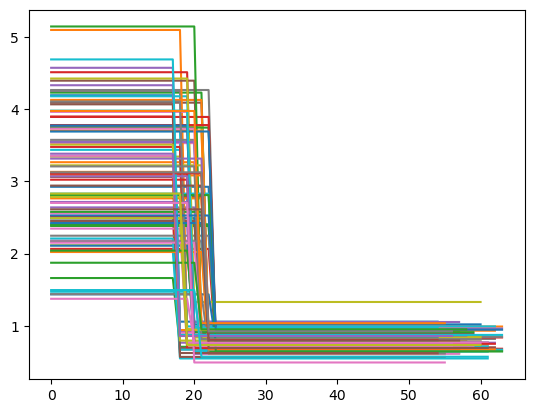

In [44]:
for R in Rs:
    plt.plot(R)

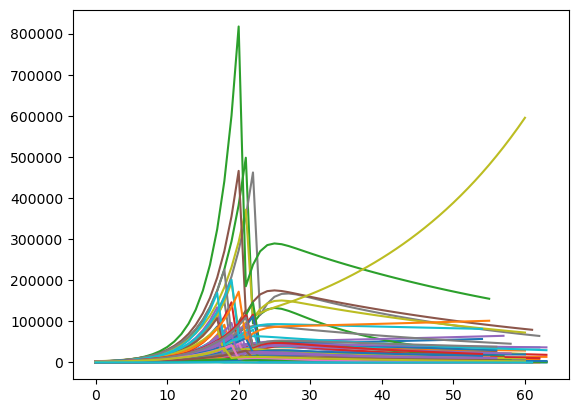

In [45]:
for I in Is:
    plt.plot(I)

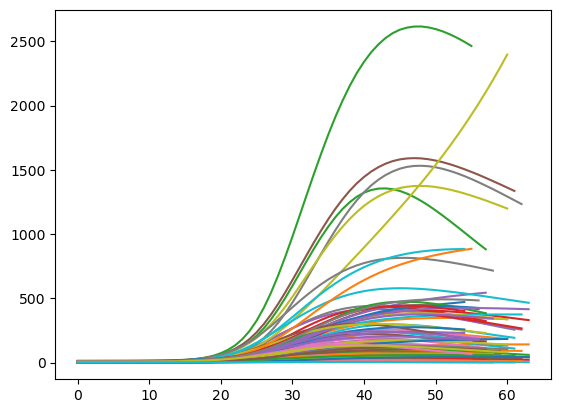

In [46]:
for EY in EYs:
    plt.plot(EY)

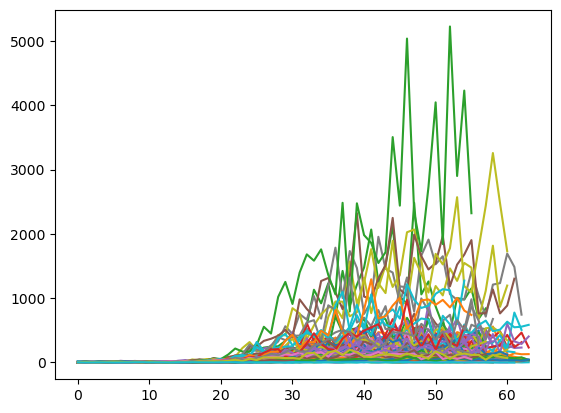

In [47]:
for Y in Ys:
    plt.plot(Y)

# 3. Save Data

In [48]:
from string import ascii_lowercase
from itertools import product

region_names = np.array([
    ''.join(combo) for combo in product(ascii_lowercase, repeat=2)
])

In [49]:
data = {'region': region_names[np.repeat(np.arange(num_region), Ts)],
        'date': np.concatenate([np.arange(T) for T in Ts]),
        'R': np.concatenate(Rs),
        'EI': np.concatenate(Is),
        'infection': np.concatenate(Is),
        'EY': np.concatenate(EYs),
        'death': np.concatenate(Ys),
        'intervention': np.concatenate(As, 0)[:,1]}

In [50]:
df = pd.DataFrame(data)

In [51]:
df

,region,date,R,EI,infection,EY,death,intervention
0,aa,0,4.190815,1387.980437,1387.980437,3.166483,1,0
1,aa,1,4.190815,1469.145966,1469.145966,3.187928,2,0
2,aa,2,4.190815,1770.304230,1770.304230,3.207031,1,0
3,aa,3,4.190815,2267.440504,2267.440504,3.225412,2,0
4,aa,4,4.190815,2945.675941,2945.675941,3.247837,3,0
...,...,...,...,...,...,...,...,...
5926,dv,57,0.571112,29.445024,29.445024,1.873777,3,1
5927,dv,58,0.571112,27.371699,27.371699,1.759526,3,1
5928,dv,59,0.571112,25.444364,25.444364,1.650705,0,1
5929,dv,60,0.571112,23.652739,23.652739,1.546948,2,1


In [52]:
df.to_feather('data/simulation_ebcr_1.feather')

In [53]:
param = {'region': region_names[np.arange(num_region)],
         'mu': thetas[:,0],
         'beta[0]': thetas[:,1],
         'beta[1]': thetas[:,2]}

In [54]:
df_param = pd.DataFrame(param)

In [55]:
df_param.to_feather('data/param_ebcr_1.feather')

(-4.0, 0.0)

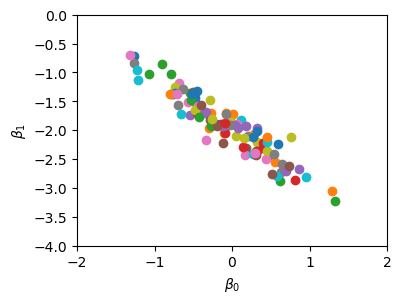

In [60]:
plt.figure(figsize=(4,3))

for i_region, theta in enumerate(thetas):
    p = plt.scatter(*(theta[1:]))
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$")
plt.xlim([-2, 2]); plt.ylim([-4, 0])

In [58]:
np.cov(thetas.T)

array([[ 0.45303057, -0.04069374,  0.04297224],
       [-0.04069374,  0.32516581, -0.28782138],
       [ 0.04297224, -0.28782138,  0.28553018]])